# Vaje 7: Nevronske mreže 1

## Naloga 1: Usmerjene (feedforward) nevronske mreže 

Z ukazom `pip3 install torch torchvision` si inštaliraj paket [PyTorch](https://pytorch.org/get-started/locally/), ki ga bomo uporabljali za nevronske mreže in ukazom `pip3 install tqdm` paket [tqdm](https://github.com/tqdm/tqdm), ki ga bomo uporabljali za izpisovanje sprotnih rezultatov


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision.transforms as transform
from torchvision.datasets import MNIST
from tqdm import tqdm

In [2]:
batch_size = 32

# Naložimo učno množico, slike pretvorimo v tenzorje in jih standardiziramo
train_set = MNIST('../Podatki/', train=True, download=True, 
                  transform=transform.Compose([transform.ToTensor(), transform.Normalize((0.1307,), (0.3081,))]))

# Naložimo testno množico, slike pretvorimo v tenzorje in jih standardiziramo
test_set = MNIST('../Podatki/', train=False, download=True, 
                 transform=transform.Compose([transform.ToTensor(), transform.Normalize((0.1307,), (0.3081,))]))

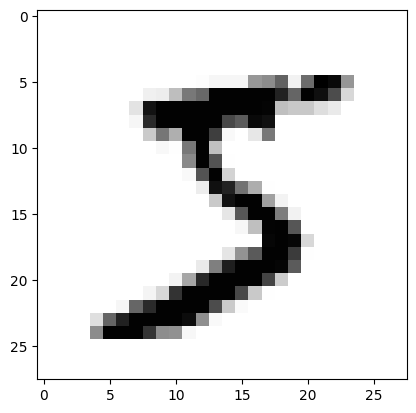

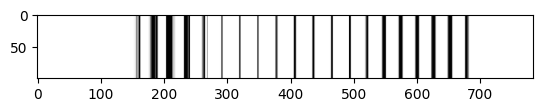

Label 5


In [3]:
# Prvo sliko pretvorimo v numpy array in jo vizualiziramo s funkcijo imshow()
first_image = train_set[0][0].numpy()[0, :, :]

# Uporabimo množico barv (colormap) "Grays", da sliko izrišemo črno-belo
plt.imshow(first_image, cmap="Greys")
plt.show()
# Za usmerjeno nevronsko mrežo bomo sliko pretvorili v vektor, zato sliko izrišemo še kot vektor
# Za lepši izris vektor ponovimo 100-krat 
# Vektor sestavim tako, da vrstice v sliki lepimo eno za drugo
plt.imshow(np.repeat(first_image.reshape((28*28, 1)).T, repeats=100, axis=0), cmap="Greys")
plt.show()

# Izpišemo ciljno vrednost prve slike
print(f"Label {train_set[0][1]}")

In [4]:
# Definiramo nevronsko mrežo, ki bo dedovala od razreda nn.Module
class NeuralNetwork(nn.Module):
    # V init definiramo sloje in morebitne stvari, ki jih bomo potrebovali
    def __init__(self):
        super().__init__()
        # Definiramo sloj, ki bo slike pretvoril v vektor.
        self.flatten = nn.Flatten()
        # Definiramo zaporedje slojev, skozi katere bomo poslali podatke.
        # Usmerjeno nevronsko mrežo lahko definiramo z uporab nn.Sequential, 
        # lahko bi se pa temu tudi izognili in definirali vsak sloj posebaj.
        self.linear_relu_stack = nn.Sequential(
            # Definiramo polno-povezan sloj, ki bo na vhod prejel vhodni vektor (velikosti slike torej 28*28)
            # Izhodno število nevronov lahko sami nastavimo, na npr 64
            nn.Linear(28*28, 64),
            # Nato podatke pošljemo čez aktivacijsko funkcijo ReLu (ki je 0 za x<0 in x čene)
            nn.ReLU(),
            # Vhod v naslednji sloj biti isto število, kot izhod iz prejšnjega
            nn.Linear(64, 20),
            nn.ReLU(),
            # Napovedovali bomo števke 0-9, zato mora zadnji sloj vsebovati 10 izhodnih vrednosti
            nn.Linear(20, 10)
        )
        # Velikokrat pri klasifikaciji za zadnji sloj damo Softmax sloj, ki izhodne vrednosti pretvori v "verjetnosti"
        # Softmax spremeni vhodne vrednosti v pozitivna realna števila, ki se seštejejo v 1. Če bi softmax uporabili 
        # neskončnokrat, bi dobili za vse vrednosti 1/št izhodnih vrednosti. Ker uporabljamo CrossEntropyLoss, ki 
        # že naredi softmax nam tega sloja ni treba uporabiti
        # self.softmax = nn.Softmax(dim=1)
        

    def forward(self, x):
        # vhodne slike (podatke) x najprej prevorimo v vektroje
        x = self.flatten(x)
        # vektorje pošljemo čez definirane sloje
        logits = self.linear_relu_stack(x)
        # vrnemo izhodne vrednosti
        return logits

# Nevronsko mrežo bi nato zgradili z naslednjim ukazom
# S to nevronsko mrežo lahko že napovedujemo, a bodo napovedane mreže naključne
# Pred uporabo moramo model natrenirati
model = NeuralNetwork()

In [5]:
# Naredimo funkcijo, ki bo natrenirala naš model
def train(epochs, model, trainset, batch_size, learning_rate=0.01):
    
    # Najprej definiramo objekt s katerim bomo vzorčili podatke. Nevronske mreže se ponavadi uči iterativno, več epoh in znotraj vsake epohe več iteracij
    # V vsaki iteraciji se učimo iz ene skupine podatkov (ang. batch)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
    
    # Zagotovimo, da bo model v načinu treniranja, kjer se računajo gradienti in so aktivni vsi sloji (med evalvacijo niso nujno vsi aktivni, npr. Dropout, BatchNormalization, ...)
    model.train()
    
    # Definiramo naš optimizator. V našem primeru bo to stohastični gradientni spust (SGD) z learning rate-om 0.01
    # Lahko bi uporabili tudi Adam naprimer
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
    
    # Definiramo našo funkcijo izgube (loss). V našem primeru bo to prečna entropija.
    criterion = nn.CrossEntropyLoss()
    
    # Gremo čež epohe
    for epoch in range(epochs):

        running_loss = 0.0
        # Uporabimo funkcijo tqdm.tqdm, ki nam bo lepše, v realnem času izpisovala napredek učenja
        with tqdm(total=len(trainloader)*batch_size, desc=f'Training - Epoch: {epoch + 1}/{epochs}', unit='chunks') as prog_bar:
            # Gremo čez vse podatke v skupinah po batch_size z trainloaderjem, v našem primeru je to 32
            for i, data in enumerate(trainloader, 0):
                # Podatke razpakiramo v vhode in izhode (labele)
                inputs, labels = data

                # Počistimo (resetiramo) gradiente v podatkih
                optimizer.zero_grad()

                # Vhodne podatke spustimo čez model, ta nam vrne matriko, v kateri se vsaka vrstica sešteje v 1 (zaradi Softmax sloja)
                outputs = model(inputs)
                # Izračunamo izgubo
                loss = criterion(outputs, labels)
                # Naredimo vzvratno razširanje napake (backpropagation)
                loss.backward()
                # Naredimo en korak optimizacije
                optimizer.step()

                # Dodamo izgubo k naši vsoti izgube. S funkcijo detach poskrbimo, da ne prištejemo (in si tako shranimo) tudi gradienta
                # s funkcijo item() pa da se le vrednost in ne celoten vektor
                running_loss += loss.detach().item()

                # Posodobimo vrednosti funkcije tqdm.tqdm. Vsoto dosedanje izgube delimo s številom skupin, ki smo jih že obdelali
                prog_bar.set_postfix(**{'loss': (running_loss) / (i+1)})
                # Posodobimo progress bar
                prog_bar.update(batch_size)

    print('Finished Training')

In [6]:
def test(model, testset, batch_size):
    
    testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=True)
    criterion = nn.CrossEntropyLoss()
    # Model damo v način evalvacije. Tu se gradienti ne računajo in da se nekateri sloji deaktivirajo
    model.eval()
    test_loss = 0
    correct = 0
    counter = 0
    
    # Dodatno poskrbimo, da vektorji ne vsebujejo gradientov
    with torch.no_grad():
        with tqdm(total=len(testloader)*batch_size, desc=f'Testing', unit='chunks') as prog_bar:
            for i, data in enumerate(testloader, 0):
                inputs, labels = data
                output = model(inputs)
                test_loss += criterion(output, labels).detach().item()
                # Izberemo indekse mesta z najvišjo vrednostjo ("verjetnostjo")
                pred = output.data.max(1, keepdim=True)[1]
                # Prištejemo število primerov, kjer smo zadeli pravilno števko
                correct += pred.eq(labels.data.view_as(pred)).sum()
                prog_bar.update(batch_size)
                counter += 1
    
    print(f'Test set: Avg. loss: {test_loss/counter}, Correct predictions: {correct}/{len(testloader.dataset)}')

In [7]:
# Naštimamo random seed za pytorch, to naredimo z drugo metodo kot za python in numpy
torch.manual_seed(42)
model = NeuralNetwork()
epochs = 5

print("Accuracy on the test set before training")
print(end="")
test(model, test_set, batch_size)
print()

train(epochs, model, train_set, batch_size)
print()

print("Accuracy on the test set after training the model")
test(model, test_set, batch_size)

Accuracy on the test set before training


Testing: 100%|██████████| 10016/10016 [00:01<00:00, 8230.47chunks/s]


Test set: Avg. loss: 2.3102493872657752, Correct predictions: 1022/10000



Training - Epoch: 5/5: 100%|██████████| 60000/60000 [00:10<00:00, 5983.98chunks/s, loss=0.137]


Finished Training

Accuracy on the test set after training the model


Testing: 100%|██████████| 10016/10016 [00:01<00:00, 8051.46chunks/s]

Test set: Avg. loss: 0.1352705263172666, Correct predictions: 9591/10000


1.a: Preveri število parametrov v natreniranem modelu. Pomagaj si z modelovo funkcijo `parameters()` in funkcijo tenzorja `numel()`, ki izpiše število vrednosti znotraj tenzorja. Kako se število parametrov primerja z dosedaj videnimi napovednimi modeli in kaj predstavljajo vmesne vrednosti na sodih mestih?

In [8]:
# Gremo čez matrike parametrov in za vsako izpišemo koliko parametrov vsebuje
for i, parameter in enumerate(model.parameters()):
    print(f"Number of parameters at layer {i}: {parameter.numel()}")
    
# Opazimo lahko, da so števila na sodih mestih nižja in da sovpadajo s številom izhodnih vrednosti slojev. To je zato, ker predstavljajo začeetne vrednosti vsakega sloja.

Number of parameters at layer 0: 50176
Number of parameters at layer 1: 64
Number of parameters at layer 2: 1280
Number of parameters at layer 3: 20
Number of parameters at layer 4: 200
Number of parameters at layer 5: 10


1.b: Spremeni zgornjo nevronsko mrežo tako, da ji dodaš še en polno-povezan sloj in spremeni srednjo aktivacijsko funkcijo iz ReLu v Tanh in preveri njeno točnost.

In [9]:
class NeuralNetwork2(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 80),
            nn.ReLU(),
            # Dodamo nov polno-povezan sloj in aktivacijsko funkcijo Tanh
            nn.Linear(80, 40),
            nn.Tanh(),
            nn.Linear(40, 20),
            nn.ReLU(),
            nn.Linear(20, 10)
        )
        

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

In [10]:
torch.manual_seed(42)
model = NeuralNetwork2()
epochs = 5

print("Accuracy on the test set before training")
print(end="")
test(model, test_set, batch_size)
print()

train(epochs, model, train_set, batch_size)
print()

print("Accuracy on the test set after training the model")
test(model, test_set, batch_size)

Accuracy on the test set before training


Testing: 100%|██████████| 10016/10016 [00:01<00:00, 7986.73chunks/s]


Test set: Avg. loss: 2.305541713397724, Correct predictions: 1286/10000



Training - Epoch: 5/5: 100%|██████████| 60000/60000 [00:10<00:00, 5602.48chunks/s, loss=0.112]


Finished Training

Accuracy on the test set after training the model


Testing: 100%|██████████| 10016/10016 [00:01<00:00, 7768.88chunks/s]

Test set: Avg. loss: 0.11228256143581944, Correct predictions: 9663/10000


Vidimo, da je se rezultat izboljšal, čas učenja pa podaljšal.

In [11]:
for i, parameter in enumerate(model.parameters()):
    print(f"Number of parameters at layer {i}: {parameter.numel()}")
    
# Vidimo tudi, da ta model vsebuje več parametrov

Number of parameters at layer 0: 62720
Number of parameters at layer 1: 80
Number of parameters at layer 2: 3200
Number of parameters at layer 3: 40
Number of parameters at layer 4: 800
Number of parameters at layer 5: 20
Number of parameters at layer 6: 200
Number of parameters at layer 7: 10


1.c: Preiskusi točnost nevronske mreže z različnimi velikosti skupin (batch-ev), optimizatorji (SGD in Adam) in različnimi hitrostmi učenja (learning rate).

In [12]:
# Da bo učenje hitrejše uporabimo le podmnožico podatkov
from torch.utils.data import Subset
train_subset = Subset(train_set, range(5000))

In [14]:
# Preverimo točnost modela in trajanje učenja za različne velikosti skupin
for batch_size in [1, 8, 64, 512, 2048]:
    model = NeuralNetwork()
    train(epochs, model, train_subset, batch_size)
    print(f"Accuracy on the test set with batch size {batch_size}")
    test(model, test_set, batch_size)
    print()
# Opazimo, da pri manjših batch-ih učenje traja več časa, a je rezultat boljši
    
# Preverimo še različne stopnje učenja
for learning_rate in [0.001, 0.01, 0.1, 1, 10]:
    model = NeuralNetwork()
    train(epochs, model, train_subset, 32, learning_rate=learning_rate)
    print(f"Accuracy on the test set with learning rate {learning_rate}")
    test(model, test_set, 32)
    print()
# Opazimo, da se pri prenizki in previsoki stopnji model ne nauči napovedovati dobro, če pa zadanemo pravo vrednost pa se model dobro uči

Training - Epoch: 5/5: 100%|██████████| 5000/5000 [00:05<00:00, 919.11chunks/s, loss=0.105] 


Finished Training
Accuracy on the test set with batch size 1


Testing: 100%|██████████| 10000/10000 [00:02<00:00, 3595.44chunks/s]


Test set: Avg. loss: 0.2780897305503683, Correct predictions: 9261/10000



Training - Epoch: 5/5: 100%|██████████| 5000/5000 [00:01<00:00, 3717.94chunks/s, loss=0.199]


Finished Training
Accuracy on the test set with batch size 8


Testing: 100%|██████████| 10000/10000 [00:01<00:00, 6977.98chunks/s]


Test set: Avg. loss: 0.29570701474770905, Correct predictions: 9079/10000



Training - Epoch: 5/5: 100%|██████████| 5056/5056 [00:00<00:00, 6717.17chunks/s, loss=0.742]


Finished Training
Accuracy on the test set with batch size 64


Testing: 100%|██████████| 10048/10048 [00:01<00:00, 7528.41chunks/s]


Test set: Avg. loss: 0.7181831571706541, Correct predictions: 8003/10000



Training - Epoch: 5/5: 100%|██████████| 5120/5120 [00:00<00:00, 8784.85chunks/s, loss=2.22]


Finished Training
Accuracy on the test set with batch size 512


Testing: 100%|██████████| 10240/10240 [00:01<00:00, 9423.20chunks/s]


Test set: Avg. loss: 2.2040568947792054, Correct predictions: 2809/10000



Training - Epoch: 5/5: 100%|██████████| 6144/6144 [00:00<00:00, 10870.85chunks/s, loss=2.26]


Finished Training
Accuracy on the test set with batch size 2048


Testing: 100%|██████████| 10240/10240 [00:01<00:00, 9432.65chunks/s]


Test set: Avg. loss: 2.2558130741119387, Correct predictions: 1999/10000



Training - Epoch: 5/5: 100%|██████████| 5024/5024 [00:00<00:00, 6010.75chunks/s, loss=2.12]


Finished Training
Accuracy on the test set with learning rate 0.001


Testing: 100%|██████████| 10016/10016 [00:01<00:00, 8510.86chunks/s]


Test set: Avg. loss: 2.086941554904365, Correct predictions: 4336/10000



Training - Epoch: 5/5: 100%|██████████| 5024/5024 [00:00<00:00, 6220.55chunks/s, loss=0.385]


Finished Training
Accuracy on the test set with learning rate 0.01


Testing: 100%|██████████| 10016/10016 [00:01<00:00, 8021.46chunks/s]


Test set: Avg. loss: 0.41284362005349545, Correct predictions: 8800/10000



Training - Epoch: 5/5: 100%|██████████| 5024/5024 [00:00<00:00, 5103.89chunks/s, loss=0.114]


Finished Training
Accuracy on the test set with learning rate 0.1


Testing: 100%|██████████| 10016/10016 [00:01<00:00, 7973.95chunks/s]


Test set: Avg. loss: 0.25173161083017104, Correct predictions: 9233/10000



Training - Epoch: 5/5: 100%|██████████| 5024/5024 [00:00<00:00, 6173.07chunks/s, loss=2.31]


Finished Training
Accuracy on the test set with learning rate 1


Testing: 100%|██████████| 10016/10016 [00:01<00:00, 7754.23chunks/s]


Test set: Avg. loss: 2.313393832776493, Correct predictions: 1135/10000



Training - Epoch: 5/5: 100%|██████████| 5024/5024 [00:00<00:00, 5624.52chunks/s, loss=nan]


Finished Training
Accuracy on the test set with learning rate 10


Testing: 100%|██████████| 10016/10016 [00:01<00:00, 7395.77chunks/s]

Test set: Avg. loss: nan, Correct predictions: 980/10000



## Naloga 2: Konvolucijska nevronska mreža

2.a: S pomočjo 2D konvolucijskega sloja ([`nn.Conv2d`](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html)) in maxpool sloja ([`nn.MaxPool2d`](https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html)) sestavi konvolucijsko nevronsko mrežo in jo potestiraj na testni množici.

In [15]:
# Sestavimo konvolucijsko nevronsko mrežo
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        # Ker bomo delali na slikah (2d matrikah) slike ne rabimo pretvoriti v vektor
        self.convolution = nn.Sequential(
            # Začnemo s konvolucijskim slojem. Ta bo na vhod dobil 1 kanal (ker je slika črno bela)
            # na izhod pa vrnila 16 kanalov (sami definiramo koliko). Velikost konvolucijskega filtra
            # nadzorujemo z parametrom kernel_size, v našem primeru bodo filtri velikosti 3x3
            nn.Conv2d(1, 16, kernel_size=3),
            # Dobljene kanale pošljemo čez relu funkcijo
            nn.ReLU(),
            # Sliko pomanjšamo z maxpool slojem. Jedro tega bo velikosti 2 v našem primeru
            nn.MaxPool2d(kernel_size=2))

        # Na koncu bomo ciljno vrednost napovedali s polno povezanim slojem. Ta na vhod prejme kanale
        # iz prejšnjega sloja pretvorjene v vektor. Teh je 16, vsak velikosti 13x13. Velikost kanalov
        # lahko ročno izračunamo ali pa model poženemo in razberemo velikost vektorja iz napake.
        self.fc = nn.Linear(16*13*13, 10)
    
    def forward(self, x):
        # Podatke pošljemo čez konvolucijo
        x = self.convolution(x)
        # Kanale pretvorimo v vektorje z ukazom reshape
        x = x.reshape(x.size(0), -1)
        # Napovemo ciljno vrednost s polno povezanim slojem
        x = self.fc(x)
        return x

In [17]:
torch.manual_seed(42)
model = CNN()
epochs = 5
batch_size = 32

print("Accuracy on the test set before training")
print(end="")
test(model, test_set, batch_size)
print()

train(epochs, model, train_set, batch_size)
print()

print("Accuracy on the test set after training the model")
test(model, test_set, batch_size)

Accuracy on the test set before training


Testing: 100%|██████████| 10016/10016 [00:01<00:00, 7000.55chunks/s]


Test set: Avg. loss: 2.3887506384438217, Correct predictions: 1002/10000



Training - Epoch: 5/5: 100%|██████████| 60000/60000 [00:12<00:00, 4707.20chunks/s, loss=0.0794]


Finished Training

Accuracy on the test set after training the model


Testing: 100%|██████████| 10016/10016 [00:01<00:00, 7150.52chunks/s]

Test set: Avg. loss: 0.07268371277253706, Correct predictions: 9778/10000


2.b: Izpiši število parametrov te nevronske mreže. Kako se število parametrov razlikuje od števila parametrov usmerjene nevronske mreže?

In [18]:
for parameter in model.parameters():
    print(parameter.numel())
    
# Vidimo, da s konvolucijsko mrežo dobimo boljše rezultate, čeprav vsebuje manj parametrov

144
16
27040
10


2.C: Modelu dodaj še en konvolucijski sloj in maxpooling sloj, ga natreniraj, preveri njegovo točnost na testni množici in preveri koliko parametrov ima. Opaziš kaj nenavadnega?

In [19]:
class CNN2(nn.Module):
    def __init__(self):
        super(CNN2, self).__init__()

        self.convolution = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(16, 32, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2))

        self.fc = nn.Linear(32*5*5, 10)
        
        
    
    def forward(self, x):
        x = self.convolution(x)
        x = x.reshape(x.size(0), -1)
        x = self.fc(x)
        return x

In [20]:
torch.manual_seed(42)
model = CNN2()
epochs = 5

print("Accuracy on the test set before training")
print(end="")
test(model, test_set, batch_size)
print()

train(epochs, model, train_set, batch_size)
print()

print("Accuracy on the test set after training the model")
test(model, test_set, batch_size)

Accuracy on the test set before training


Testing: 100%|██████████| 10016/10016 [00:01<00:00, 6971.63chunks/s]


Test set: Avg. loss: 2.346103991944188, Correct predictions: 518/10000



Training - Epoch: 5/5: 100%|██████████| 60000/60000 [00:14<00:00, 4103.11chunks/s, loss=0.0599]


Finished Training

Accuracy on the test set after training the model


Testing: 100%|██████████| 10016/10016 [00:01<00:00, 6918.11chunks/s]

Test set: Avg. loss: 0.052435017226951215, Correct predictions: 9832/10000


In [21]:
for parameter in model.parameters():
    print(parameter.numel())
    
# Čeprav smo dodali več slojev, se je število parametrov zmanjšalo, točnost modela pa se je povečala
# Razlog za manjše število parametrov je manjša vhodna dimenzija polno-povezanega sloja, saj so kanali,
# ki jih dobimo iz drugega maxpool sloja manjši.

144
16
4608
32
8000
10


## Dodatna naloga: Eksperimenti z nevronskimi mrežami

D.a: Poigraj se z naslednjimi parametri, da dobiš čim boljši model:
- število konvolucijskih slojev v mreži
- število polno-povezanih slojev v mreži
- velikost jedra konvolucijskega sloja
- velikost jedra maxpool sloja
- število nevronov v polno povezanih slojih
- število izhodnih kanalov konvolucijskega sloja
- hitrost učenja
- optimizator (Adam)

D.b: Opiši, kako bi z nevronsko mrežo sestavil model linearne regresije, ki se parametrov nauči iterativno in ne eksaktno.